In [1]:
from __future__ import absolute_import, print_function

import argparse, json, os, requests, sys, time
from io import BytesIO
from os.path import join, isfile
from PIL import Image

#from mxnet.gluon.model_zoo import vision
import numpy as np
from matplotlib import pyplot as plt

import tvm
from tvm import te
from tvm import rpc, autotvm, relay
from tvm.contrib import graph_runtime, utils, download
from tvm.relay import transform

import vta
from vta.testing import simulator
from vta.top import graph_pack

import torch
import torchvision
from tvm.contrib.download import download_testdata



# Make sure that TVM was compiled with RPC=1
assert tvm.runtime.enabled("rpc")

/home/srchand/anaconda3/envs/tvm-build-il-2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load VTA parameters from the 3rdparty/vta-hw/config/vta_config.json file
env = vta.get_env()

# Set ``device=arm_cpu`` to run inference on the CPU
# or ``device=vta`` to run inference on the FPGA.
device = "vta"
target = env.target if device == "vta" else env.target_vta_cpu

# Dictionary lookup for when to start/end bit packing
pack_dict = {
    #"resnet18_v1": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet18": ["nn.max_pool2d", "nn.adaptive_avg_pool2d"],
    "resnet34": ["nn.max_pool2d", "nn.adaptive_avg_pool2d"],
    "resnet50": ["nn.max_pool2d", "nn.adaptive_avg_pool2d"],
    "resnet101": ["nn.max_pool2d", "nn.adaptive_avg_pool2d"],
    "vgg11":    ["nn.max_pool2d", "nn.adaptive_avg_pool2d"],
    "resnet34_v1": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet18_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet34_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet50_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet101_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
}

# Name of Gluon model to compile
# The ``start_pack`` and ``stop_pack`` labels indicate where
# to start and end the graph packing relay pass: in other words
# where to start and finish offloading to VTA.
#model = "resnet18_v1"
#assert model in pack_dict
model = "vgg11"

In [3]:
remote = None
if env.TARGET not in ["sim", "tsim", "intelfocl"]:

    # Get remote from tracker node if environment variable is set.
    # To set up the tracker, you'll need to follow the "Auto-tuning
    # a convolutional network for VTA" tutorial.
    tracker_host = os.environ.get("TVM_TRACKER_HOST", None)
    tracker_port = os.environ.get("TVM_TRACKER_PORT", None)
    # Otherwise if you have a device you want to program directly from
    # the host, make sure you've set the variables below to the IP of
    # your board.
    #device_host = os.environ.get("VTA_RPC_HOST", "192.168.2.99")
    device_host = "192.168.2.99"
#     device_host="10.100.84.133"

    device_port = os.environ.get("VTA_RPC_PORT", "9091")
    if not tracker_host or not tracker_port:
        remote = rpc.connect(device_host, int(device_port))
    else:
        remote = autotvm.measure.request_remote(
            env.TARGET, tracker_host, int(tracker_port), timeout=10000
        )

    # Reconfigure the JIT runtime and FPGA.
    # You can program the FPGA with your own custom bitstream
    # by passing the path to the bitstream file instead of None.
    reconfig_start = time.time()
    vta.reconfig_runtime(remote)
    #vta.program_fpga(remote, bitstream="/home/srchand/Desktop/overlays/vta_il/vta_apm_maxigp0_wrapper.bit")
    #vta.program_fpga(remote, bitstream=None)
#     vta.program_fpga(remote, bitstream="/home/srchand/Desktop/research/TVM_Intel_Fork/tvm/vta/sri_scripts/bitstreams/vta_zcu104_wrapper.bit")
#     vta.program_fpga(remote, bitstream="/mnt/hgfs/vmware_ubuntu_sf/bitstreams/vta_axi_sniffer_uart_fifo_thres_100.bit")
#     vta.program_fpga(remote, bitstream="/mnt/hgfs/vmware_ubuntu_sf/bitstreams/vta_axi_sniffer_uart_rx_tx_hex.bit")

    reconfig_time = time.time() - reconfig_start
    print("Reconfigured FPGA and RPC runtime in {0:.2f}s!".format(reconfig_time))

# In simulation mode, host the RPC server locally.
else:
    remote = rpc.LocalSession()

    if env.TARGET in ["intelfocl"]:
        # program intelfocl aocx
        vta.program_fpga(remote, bitstream="vta.bitstream")

# Get execution context from remote
ctx = remote.ext_dev(0) if device == "vta" else remote.cpu(0)

Reconfigured FPGA and RPC runtime in 4.38s!


In [4]:
from torch import nn
from torch.nn import functional as F

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for i in range(num_convs):
        if i == 0:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        else:
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

class VGG():
    def __init__(self, arch):
        super().__init__()
        conv_blks = []
        for (num_convs, in_channels, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.AdaptiveAvgPool2d((1,1)))
        
# net1 = nn.Sequential(b1,b5,nn.AdaptiveAvgPool2d((1,1)))


In [5]:
net1 = VGG(arch=((1, 3, 64), (1, 64, 128), (2, 128, 256), (2, 256, 512), (2, 512, 512))).net

In [17]:
net1

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4):

In [6]:
import glob
schedule_log_files = glob.glob(r'/home/srchand/Desktop/research/TVM_Intel_Fork/tvm/vta/sri_scripts/logs/tuning_logs/*.log')

In [7]:
# Load pre-configured AutoTVM schedules
with autotvm.tophub.context(target, extra_files=schedule_log_files):
    
    input_name = "input0"

    # Populate the shape and data type dictionary for ImageNet classifier input
    dtype_dict = {input_name: "float32"}
    shape_dict = {input_name: (env.BATCH, 3, 224, 224)}


    # Get off the shelf gluon model, and convert to relay
    #gluon_model = vision.get_model(model, pretrained=True)
    
    
    #pytorch_model = getattr(torchvision.models, model)(pretrained=True)
    #pytorch_model = net2
    
    input_shape = [1, 3, 224, 224]
    input_data = torch.randn(input_shape)
    #scripted_model1 = torch.jit.trace(pytorch_model, input_data).eval()
        
    scripted_model1 = torch.jit.trace(net1, input_data).eval()
#     scripted_model2 = torch.jit.trace(net2, input_data).eval()
#     scripted_model3 = torch.jit.trace(net3, input_data).eval()
#     scripted_model4 = torch.jit.trace(net4, input_data).eval()
    
    #net(mx.nd.array(input_data.numpy()))

    
    shape_list = [(input_name, input_shape)]


    # Measure build start time
    build_start = time.time()

    # Start front end compilation
    #mod, params = relay.frontend.from_pytorch(scripted_model, shape_list)
    mod1, params1 = relay.frontend.from_pytorch(scripted_model1, shape_list)
#     mod2, params2 = relay.frontend.from_pytorch(scripted_model2, shape_list)
#     mod3, params3 = relay.frontend.from_pytorch(scripted_model3, shape_list)
#     mod4, params4 = relay.frontend.from_pytorch(scripted_model4, shape_list)
    
    
    
    #mod, params = relay.frontend.from_mxnet(gluon_model, shape_dict)

    #mod, params = relay.frontend.from_mxnet(net, shape_dict)
    
    # Update shape and type dictionary
    shape_dict.update({k: v.shape for k, v in params1.items()})
    dtype_dict.update({k: str(v.dtype) for k, v in params1.items()})

    if target.device_name == "vta":
        # Perform quantization in Relay
        # Note: We set opt_level to 3 in order to fold batch norm
        with tvm.transform.PassContext(opt_level=3):
            with relay.quantize.qconfig(global_scale=8.0, skip_conv_layers=[0]):
                mod1 = relay.quantize.quantize(mod1, params=params1)
#                 print(mod1.astext(show_meta_data=False))
#                 print(apput)
#                 mod2 = relay.quantize.quantize(mod2, params=params2)
#                 mod3 = relay.quantize.quantize(mod3, params=params3)
#                 mod4 = relay.quantize.quantize(mod4, params=params4)
                
                
                
            # Perform graph packing and constant folding for VTA target
            assert env.BLOCK_IN == env.BLOCK_OUT
            # do device annotation if target is intelfocl or sim
            relay_prog1 = graph_pack(
                mod1["main"],
                env.BATCH,
                env.BLOCK_IN,
                env.BLOCK_OUT,
                env.WGT_WIDTH,
#                 start_name=pack_dict[model][0],
#                 stop_name=pack_dict[model][1],
                start_name="cast",
                stop_name="cast",
                start_name_idx=8,
                stop_name_idx=71,
                #start_name='nn.max_pool2d',
                device_annot=(env.TARGET == "intelfocl"),
            )
            
#             relay_prog2 = graph_pack(
#                 mod2["main"],
#                 env.BATCH,
#                 env.BLOCK_IN,
#                 env.BLOCK_OUT,
#                 env.WGT_WIDTH,
#                 start_name=pack_dict[model][0],
#                 stop_name=pack_dict[model][1],
#                 #start_name='nn.max_pool2d',
#                 #stop_name='nn.adaptive_avg_pool2d',
#                 device_annot=(env.TARGET == "intelfocl"),
#             )
#             relay_prog3 = graph_pack(
#                 mod3["main"],
#                 env.BATCH,
#                 env.BLOCK_IN,
#                 env.BLOCK_OUT,
#                 env.WGT_WIDTH,
#                 start_name=pack_dict[model][0],
#                 stop_name=pack_dict[model][1],
#                 #start_name='nn.max_pool2d',
#                 #stop_name='nn.adaptive_avg_pool2d',
#                 device_annot=(env.TARGET == "intelfocl"),
#             )
#             relay_prog4 = graph_pack(
#                 mod4["main"],
#                 env.BATCH,
#                 env.BLOCK_IN,
#                 env.BLOCK_OUT,
#                 env.WGT_WIDTH,
#                 start_name=pack_dict[model][0],
#                 stop_name=pack_dict[model][1],
#                 #start_name='nn.max_pool2d',
#                 #stop_name='nn.adaptive_avg_pool2d',
#                 device_annot=(env.TARGET == "intelfocl"),
#             )
            
        
    else:
        relay_prog = mod1["main"]

    # Compile Relay program with AlterOpLayout disabled
    if target.device_name != "vta":
        with tvm.transform.PassContext(opt_level=3, disabled_pass={"AlterOpLayout"}):
            graph, lib, params = relay.build(
                relay_prog, target=target, params=params, target_host=env.target_host
            )
    else:
        if env.TARGET == "intelfocl":
            # multiple targets to run both on cpu and vta
            target = {"cpu": env.target_vta_cpu, "ext_dev": target}
        with vta.build_config(opt_level=3, disabled_pass={"AlterOpLayout"}):
            graph1, lib1, params1 = relay.build(
                relay_prog1, target=target, params=params1, target_host=env.target_host
            )
            
#             graph2, lib2, params2 = relay.build(
#                 relay_prog2, target=target, params=params2, target_host=env.target_host
#             )
#             graph3, lib3, params3 = relay.build(
#                 relay_prog3, target=target, params=params3, target_host=env.target_host
#             )
#             graph4, lib4, params4 = relay.build(
#                 relay_prog4, target=target, params=params4, target_host=env.target_host
#             )
            

    # Measure Relay build time
    build_time = time.time() - build_start
    print(model + " inference graph built in {0:.2f}s!".format(build_time))

    # Send the inference library over to the remote RPC server
    temp = utils.tempdir()
    lib1.export_library(temp.relpath("graphlib1.tar"))
    remote.upload(temp.relpath("graphlib1.tar"))
    lib1 = remote.load_module("graphlib1.tar")

#     lib2.export_library(temp.relpath("graphlib2.tar"))
#     remote.upload(temp.relpath("graphlib2.tar"))
#     lib2 = remote.load_module("graphlib2.tar")
    
#     lib3.export_library(temp.relpath("graphlib3.tar"))
#     remote.upload(temp.relpath("graphlib3.tar"))
#     lib3 = remote.load_module("graphlib3.tar")
    
#     lib4.export_library(temp.relpath("graphlib4.tar"))
#     remote.upload(temp.relpath("graphlib4.tar"))
#     lib4 = remote.load_module("graphlib4.tar")

    if env.TARGET == "intelfocl":
        ctxes = [remote.ext_dev(0), remote.cpu(0)]
        m = graph_runtime.create(graph, lib, ctxes)
    else:
        # Graph runtime
        m1 = graph_runtime.create(graph1, lib1, ctx)
#         m2 = graph_runtime.create(graph2, lib2, ctx)
#         m3 = graph_runtime.create(graph3, lib3, ctx)
#         m4 = graph_runtime.create(graph4, lib4, ctx)

Cannot find config for target=ext_dev -keys=vta,cpu -device=vta -model=zcu104_1x16x16_i8w8a32_15_15_18_17, workload=('pooling_packed.vta', ('TENSOR', (1, 32, 14, 14, 1, 16), 'int32'), (2, 2), (2, 2), (0, 0, 0, 0), 'max', 0, 'NCHW1n16c', 1). A fallback configuration is used, which may bring great performance regression.


Acc utilization: 3920 elems
Acc size: 32768 elems


Cannot find config for target=ext_dev -keys=vta,cpu -device=vta -model=zcu104_1x16x16_i8w8a32_15_15_18_17, workload=('pooling_packed.vta', ('TENSOR', (1, 32, 28, 28, 1, 16), 'int32'), (2, 2), (2, 2), (0, 0, 0, 0), 'max', 0, 'NCHW1n16c', 1). A fallback configuration is used, which may bring great performance regression.


Acc utilization: 15680 elems
Acc size: 32768 elems


Cannot find config for target=ext_dev -keys=vta,cpu -device=vta -model=zcu104_1x16x16_i8w8a32_15_15_18_17, workload=('pooling_packed.vta', ('TENSOR', (1, 16, 56, 56, 1, 16), 'int32'), (2, 2), (2, 2), (0, 0, 0, 0), 'max', 0, 'NCHW1n16c', 1). A fallback configuration is used, which may bring great performance regression.


Splitting into row to reduce scratchpad utilization
Acc utilization: 2240 elems
Acc size: 32768 elems


Cannot find config for target=ext_dev -keys=vta,cpu -device=vta -model=zcu104_1x16x16_i8w8a32_15_15_18_17, workload=('pooling_packed.vta', ('TENSOR', (1, 8, 112, 112, 1, 16), 'int32'), (2, 2), (2, 2), (0, 0, 0, 0), 'max', 0, 'NCHW1n16c', 1). A fallback configuration is used, which may bring great performance regression.


Splitting into row to reduce scratchpad utilization
Acc utilization: 4480 elems
Acc size: 32768 elems


Cannot find config for target=ext_dev -keys=vta,cpu -device=vta -model=zcu104_1x16x16_i8w8a32_15_15_18_17, workload=('conv2d_nchw_spatial_pack.arm_cpu', ('TENSOR', (1, 3, 224, 224), 'float32'), ('TENSOR', (64, 3, 3, 3), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'float32'). A fallback configuration is used, which may bring great performance regression.
/tmp/ipykernel_5930/2656490659.py:138: DeprecationWarning: legacy graph runtime behavior of producing json / lib / params will be removed in the next release. Please see documents of tvm.contrib.graph_runtime.GraphModule for the  new recommended usage.
  graph1, lib1, params1 = relay.build(


vgg11 inference graph built in 7.15s!


In [18]:
print(mod1.astext(show_meta_data=False))

#[version = "0.0.5"]
def @main(%input0: Tensor[(1, 3, 224, 224), float32]) -> Tensor[(1, 512, 1, 1), float32] {
  %0 = nn.conv2d(%input0, meta[relay.Constant][0] /* ty=Tensor[(64, 3, 3, 3), float32] */, padding=[1, 1, 1, 1], channels=64, kernel_size=[3, 3]) /* ty=Tensor[(1, 64, 224, 224), float32] */;
  %1 = add(%0, meta[relay.Constant][1] /* ty=Tensor[(64, 1, 1), float32] */) /* ty=Tensor[(1, 64, 224, 224), float32] */;
  %2 = nn.relu(%1) /* ty=Tensor[(1, 64, 224, 224), float32] */;
  %3 = nn.max_pool2d(%2, pool_size=[2, 2], strides=[2, 2], padding=[0, 0, 0, 0]) /* ty=Tensor[(1, 64, 112, 112), float32] */;
  %4 = annotation.stop_fusion(%3) /* ty=Tensor[(1, 64, 112, 112), float32] */;
  %5 = multiply(%4, 16f /* ty=float32 */) /* ty=Tensor[(1, 64, 112, 112), float32] */;
  %6 = round(%5) /* ty=Tensor[(1, 64, 112, 112), float32] */;
  %7 = clip(%6, a_min=-127f, a_max=127f) /* ty=Tensor[(1, 64, 112, 112), float32] */;
  %8 = cast(%7, dtype="int8") /* ty=Tensor[(1, 64, 112, 112), int8] */;

In [ ]:
help(lib1)

In [ ]:
import subprocess
import time
proc = subprocess.Popen(["sshpass", "-p" ,"srivat95" ,"ssh", "-t" ,"xilinx@192.168.2.99" ,"sudo", "python3" ,"/home/xilinx/tvm/vta/python/vta/poll_apm.py" ,"--slot" ,"0"],stdout=subprocess.PIPE,stderr=subprocess.PIPE)
count=0
for i in range(100000000):
    count+=1
    



File synset.txt exists, skip.


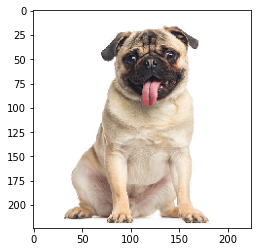


Performed inference in 163.63ms (std = 0.00) for 1 samples
Average per sample inference time: 163.63ms
done


In [14]:
import multiprocessing as mp
import threading as tr

#p = mp.Process(target=read_apm, args=('bob',))
#t1 = tr.Thread(target=read_apm, args=('bob',))
#pool = mp.Pool(4)
# Download ImageNet categories
categ_url = "https://github.com/uwsampl/web-data/raw/main/vta/models/"
categ_fn = "synset.txt"
download.download(join(categ_url, categ_fn), categ_fn)
synset = eval(open(categ_fn).read())

# Download test image
image_url = "https://homes.cs.washington.edu/~moreau/media/vta/cat.jpg"
image_fn = "pug.jpg"
#download.download(image_url, image_fn)

# Prepare test image for inference
image = Image.open(image_fn).resize((224, 224))
plt.imshow(image)
plt.show()
image = np.array(image) - np.array([123.0, 117.0, 104.0])
image /= np.array([58.395, 57.12, 57.375])
image = image.transpose((2, 0, 1))
image = image[np.newaxis, :]
image = np.repeat(image, env.BATCH, axis=0)

# Set the network parameters and inputs
m1.set_input(**params1)
m1.set_input(input_name, image)
# m2.set_input(**params1)
# m2.set_input(input_name, image)
# m3.set_input(**params1)
# m3.set_input(input_name, image)
# m4.set_input(**params1)
# m4.set_input(input_name, image)

# Perform inference and gather execution statistics
# More on: :py:method:`tvm.runtime.Module.time_evaluator`
num = 9  # number of times we run module for a single measurement
rep = 1  # number of measurements (we derive std dev from this)


timer = m1.module.time_evaluator("run", ctx, number=num, repeat=rep)


#timer = m.module.time_evaluator("run", ctx, number=num, repeat=rep)
#

if env.TARGET in ["sim", "tsim"]:
    simulator.clear_stats()
    timer()
    sim_stats = simulator.stats()
    print("\nExecution statistics:")
    for k, v in sim_stats.items():
        # Since we execute the workload many times, we need to normalize stats
        # Note that there is always one warm up run
        # Therefore we divide the overall stats by (num * rep + 1)
        print("\t{:<16}: {:>16}".format(k, v // (num * rep + 1)))
else:
    #vta.init_apm(remote)
#     vta.reset_ro_monitor(remote)
#     vta.start_ro_monitor(remote)
    tcost = timer()
#     vta.stop_ro_monitor(remote,0)
    #vta.read_metrics(remote,0)
#     m1.run()
    #vta.reset_apm(remote)
    std = np.std(tcost.results) * 1000
    mean = tcost.mean * 1000
    print("\nPerformed inference in %.2fms (std = %.2f) for %d samples" % (mean, std, env.BATCH))
    print("Average per sample inference time: %.2fms" % (mean / env.BATCH))

print("done")
    # Get classification results
# tvm_output = m.get_output(0, tvm.nd.empty((env.BATCH, 1000), "float32", remote.cpu(0)))
# for b in range(env.BATCH):
#     top_categories = np.argsort(tvm_output.numpy()[b])
#     # Report top-5 classification results
#     print("\n{} prediction for sample {}".format(model, b))
#     print("\t#1:", synset[top_categories[-1]])
#     print("\t#2:", synset[top_categories[-2]])
#     print("\t#3:", synset[top_categories[-3]])
#     print("\t#4:", synset[top_categories[-4]])
#     print("\t#5:", synset[top_categories[-5]])
#     # This just checks that one of the 5 top categories
#     # is one variety of cat; this is by no means an accurate
#     # assessment of how quantization affects classification
#     # accuracy but is meant to catch changes to the
#     # quantization pass that would accuracy in the CI.
#     cat_detected = False
#     for k in top_categories[-5:]:
#         if "pug" in synset[k]:
#             cat_detected = True
#     assert cat_detected

In [16]:
# Perform inference and gather execution statistics
# More on: :py:method:`tvm.runtime.Module.time_evaluator`
num = 9  # number of times we run module for a single measurement
rep = 1  # number of measurements (we derive std dev from this)


timer = m1.module.time_evaluator("run", ctx, number=num, repeat=rep)


#timer = m.module.time_evaluator("run", ctx, number=num, repeat=rep)
#

if env.TARGET in ["sim", "tsim"]:
    simulator.clear_stats()
    timer()
    sim_stats = simulator.stats()
    print("\nExecution statistics:")
    for k, v in sim_stats.items():
        # Since we execute the workload many times, we need to normalize stats
        # Note that there is always one warm up run
        # Therefore we divide the overall stats by (num * rep + 1)
        print("\t{:<16}: {:>16}".format(k, v // (num * rep + 1)))
else:
    #vta.init_apm(remote)
#     vta.reset_ro_monitor(remote)
#     vta.start_ro_monitor(remote)
#     tcost = timer()
#     vta.stop_ro_monitor(remote,0)
    #vta.read_metrics(remote,0)
    m1.run()
    #vta.reset_apm(remote)
#     std = np.std(tcost.results) * 1000
#     mean = tcost.mean * 1000
#     print("\nPerformed inference in %.2fms (std = %.2f) for %d samples" % (mean, std, env.BATCH))
#     print("Average per sample inference time: %.2fms" % (mean / env.BATCH))

print("done")
    # Get classification results
# tvm_output = m.get_output(0, tvm.nd.empty((env.BATCH, 1000), "float32", remote.cpu(0)))
# for b in range(env.BATCH):
#     top_categories = np.argsort(tvm_output.numpy()[b])
#     # Report top-5 classification results
#     print("\n{} prediction for sample {}".format(model, b))
#     print("\t#1:", synset[top_categories[-1]])
#     print("\t#2:", synset[top_categories[-2]])
#     print("\t#3:", synset[top_categories[-3]])
#     print("\t#4:", synset[top_categories[-4]])
#     print("\t#5:", synset[top_categories[-5]])
#     # This just checks that one of the 5 top categories
#     # is one variety of cat; this is by no means an accurate
#     # assessment of how quantization affects classification
#     # accuracy but is meant to catch changes to the
#     # quantization pass that would accuracy in the CI.
#     cat_detected = False
#     for k in top_categories[-5:]:
#         if "pug" in synset[k]:
#             cat_detected = True
#     assert cat_detected

done


In [ ]:
while True:
    line = proc.stdout.readline()
    if not line:
        break
    print(line)

In [ ]:
help(remote)

In [ ]:
from torch import nn
avgpool = nn.AdaptiveAvgPool2d((1,1))

In [ ]:
input = torch.randn(1,512,7,7)
output = avgpool(input)
torch.flatten(output).shape

In [ ]:
import json
my_json = graph
parsed = json.loads(my_json)
print(json.dumps(parsed, indent=4, sort_keys=True))